# BIG DATA AND MLOPS FINAL PROJECT
##Improving Loan Risk Assessment and Approval Process Using Big Data Analytics

### Phase 1: Data Selection & Problem Definition

**PROBLEM** Improving Loan Risk Assessment and Approval Process Using Big Data Analytics


**DATASET:** Loan Default Dataset




### Phase 2: Data Ingestion & Preprocessing

In [0]:
#Data Ingestion
loan_data=spark.read.format("csv").option("header","true").option("inferSchema","true").load("/FileStore/tables/Loan_default.csv")

In [0]:
# Show dataset preview
loan_data.show(5)
loan_data.printSchema()

# Step 2: Create Temporary View for SQL Queries
loan_data.createOrReplaceTempView("LoanData")



+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|I38PQUQS96| 56| 85994|     50587|        520|            80|             4|       15.23|      36|    0.44| Bachelor's|     Full-time|     Divorced|        Yes|          Yes|      Other|        Yes|      0|
|HPSK72WA7R| 69| 50432|    124440|        458|            15|             1|        4.81|      60|    0.68|   Master's|     Full-time|      Married|         No|           N

Use Hive or Spark SQL for data exploration and cleaning.

In [0]:
%sql
--Total Unique Loans
SELECT COUNT(DISTINCT Loanid) AS unique_loans FROM LoanData;


unique_loans
255347


In [0]:
%sql
--Check for Missing Values in Each Column
SELECT 
    SUM(CASE WHEN LoanID IS NULL THEN 1 ELSE 0 END) AS missing_LoanID,
    SUM(CASE WHEN Age IS NULL THEN 1 ELSE 0 END) AS missing_Age,
    SUM(CASE WHEN Income IS NULL THEN 1 ELSE 0 END) AS missing_Income,
    SUM(CASE WHEN LoanAmount IS NULL THEN 1 ELSE 0 END) AS missing_LoanAmount,
    SUM(CASE WHEN CreditScore IS NULL THEN 1 ELSE 0 END) AS missing_CreditScore,
    SUM(CASE WHEN MonthsEmployed IS NULL THEN 1 ELSE 0 END) AS missing_MonthsEmployed,
    SUM(CASE WHEN NumCreditLines IS NULL THEN 1 ELSE 0 END) AS missing_NumCreditLines,
    SUM(CASE WHEN InterestRate IS NULL THEN 1 ELSE 0 END) AS missing_InterestRate,
    SUM(CASE WHEN LoanTerm IS NULL THEN 1 ELSE 0 END) AS missing_LoanTerm,
    SUM(CASE WHEN DTIRatio IS NULL THEN 1 ELSE 0 END) AS missing_DTIRatio,
    SUM(CASE WHEN Education IS NULL THEN 1 ELSE 0 END) AS missing_Education,
    SUM(CASE WHEN EmploymentType IS NULL THEN 1 ELSE 0 END) AS missing_EmploymentType,
    SUM(CASE WHEN MaritalStatus IS NULL THEN 1 ELSE 0 END) AS missing_MaritalStatus,
    SUM(CASE WHEN HasMortgage IS NULL THEN 1 ELSE 0 END) AS missing_HasMortgage,
    SUM(CASE WHEN HasDependents IS NULL THEN 1 ELSE 0 END) AS missing_HasDependents,
    SUM(CASE WHEN LoanPurpose IS NULL THEN 1 ELSE 0 END) AS missing_LoanPurpose,
    SUM(CASE WHEN HasCoSigner IS NULL THEN 1 ELSE 0 END) AS missing_HasCoSigner,
    SUM(CASE WHEN Default IS NULL THEN 1 ELSE 0 END) AS missing_Default
FROM LoanData;


missing_LoanID,missing_Age,missing_Income,missing_LoanAmount,missing_CreditScore,missing_MonthsEmployed,missing_NumCreditLines,missing_InterestRate,missing_LoanTerm,missing_DTIRatio,missing_Education,missing_EmploymentType,missing_MaritalStatus,missing_HasMortgage,missing_HasDependents,missing_LoanPurpose,missing_HasCoSigner,missing_Default
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
%sql
--Distribution of Loan Defaults (Default vs. Non-Default)
SELECT Default, COUNT(*) AS count, 
       (COUNT(*) * 100.0 / (SELECT COUNT(*) FROM LoanData)) AS percentage
FROM LoanData
GROUP BY Default
ORDER BY count DESC;


Default,count,percentage
0,225694,88.38717509898295
1,29653,11.61282490101705


In [0]:
%sql
-- Average Loan Amount by Default Status
SELECT Default, 
       AVG(LoanAmount) AS avg_loan_amount, 
       MAX(LoanAmount) AS max_loan_amount, 
       MIN(LoanAmount) AS min_loan_amount
FROM LoanData
GROUP BY Default;



Default,avg_loan_amount,max_loan_amount,min_loan_amount
1,144515.31146932856,249993,5000
0,125353.65601655339,249999,5001


In [0]:
%sql
--Credit Score Distribution
SELECT 
    CASE 
        WHEN CreditScore < 600 THEN 'Very Poor (Below 600)'
        WHEN CreditScore BETWEEN 600 AND 699 THEN 'Fair (600-699)'
        WHEN CreditScore BETWEEN 700 AND 749 THEN 'Good (700-749)'
        WHEN CreditScore BETWEEN 750 AND 850 THEN 'Excellent (750-850)'
        ELSE 'Unknown'
    END AS credit_score_category,
    COUNT(*) AS num_loans
FROM LoanData
GROUP BY credit_score_category
ORDER BY num_loans DESC;


credit_score_category,num_loans
Very Poor (Below 600),139483
Excellent (750-850),46574
Fair (600-699),46434
Good (700-749),22856


In [0]:
%sql
--Loan Default Rate by Employment Type
SELECT EmploymentType, 
       COUNT(*) AS total_loans, 
       SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) AS default_loans, 
       (SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS default_rate
FROM LoanData
GROUP BY EmploymentType
ORDER BY default_rate DESC;


EmploymentType,total_loans,default_loans,default_rate
Unemployed,63824,8650,13.55289546252194
Part-time,64161,7677,11.96521251227381
Self-employed,63706,7302,11.46202869431451
Full-time,63656,6024,9.46336559004650


In [0]:
%sql
--Loan Defaults by Income Bracket
SELECT 
    CASE 
        WHEN Income < 30000 THEN 'Low Income (<30K)'
        WHEN Income BETWEEN 30000 AND 60000 THEN 'Mid Income (30K-60K)'
        WHEN Income BETWEEN 60000 AND 100000 THEN 'Upper Mid Income (60K-100K)'
        ELSE 'High Income (>100K)'
    END AS income_bracket,
    COUNT(*) AS total_loans,
    SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) AS defaults,
    (SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS default_rate
FROM LoanData
GROUP BY income_bracket
ORDER BY default_rate DESC;


income_bracket,total_loans,defaults,default_rate
Low Income (<30K),28402,6236,21.95620026758679
Mid Income (30K-60K),56653,7242,12.78308297883607
Upper Mid Income (60K-100K),75727,7566,9.99115242912039
High Income (>100K),94565,8609,9.10379104319780


In [0]:
%sql
--Default Rate by Loan Term
SELECT LoanTerm, 
       COUNT(*) AS total_loans, 
       SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) AS default_loans,
       (SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS default_rate
FROM LoanData
GROUP BY LoanTerm
ORDER BY default_rate DESC;


LoanTerm,total_loans,default_loans,default_rate
60,51154,5983,11.69605504945850
12,50957,5920,11.61763840100477
24,51009,5921,11.60775549412849
48,51166,5922,11.57409217058203
36,51061,5907,11.56851608859991


In [0]:
%sql
-- Default Rate by Loan Purpose
 SELECT LoanPurpose, 
       COUNT(*) AS total_loans, 
       SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) AS default_loans,
       (SUM(CASE WHEN Default = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS default_rate
FROM LoanData
GROUP BY LoanPurpose
ORDER BY default_rate DESC;


LoanPurpose,total_loans,default_loans,default_rate
Business,51298,6323,12.32601660883465
Auto,50844,6041,11.88144127133978
Education,51005,6038,11.83805509263798
Other,50914,6002,11.78850610833955
Home,51286,5249,10.23476192333190


•	Handle missing values, duplicates, and perform transformations using Spark DataFrames or Hive queries.

•	Apply categorical encoding techniques like one-hot encoding (if needed).

•	Optimize data storage using Parquet/ORC formats.


In [0]:
# Databricks Notebook - Loan Default Data Preprocessing

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when, isnan
from pyspark.ml.feature import StringIndexer, OneHotEncoder
df = loan_data

# Show dataset preview
df.show(5)
df.printSchema()

# 📌 Step 2: Create Temporary View for SQL Queries
df.createOrReplaceTempView("oot")

# 📌 Step 3: Handle Missing Values
# Count missing values per column
missing_values = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
missing_values.show()

# Option 1: Drop rows with missing values (if needed)
df = df.dropna()

# Option 2: Fill missing values for specific columns (Modify based on business rules)
df = df.fillna({
    "CreditScore": df.select("CreditScore").agg({"CreditScore": "mean"}).collect()[0][0],
    "Income": df.select("Income").agg({"Income": "mean"}).collect()[0][0],
    "LoanAmount": df.select("LoanAmount").agg({"LoanAmount": "median"}).collect()[0][0]
})

# Step 4: Remove Duplicates
df = df.dropDuplicates()

# Step 5: Perform Categorical Encoding
categorical_columns = ["Education", "EmploymentType", "MaritalStatus", "HasMortgage", "HasDependents", "LoanPurpose", "HasCoSigner"]

for col_name in categorical_columns:
    if col_name in df.columns:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
        df = indexer.fit(df).transform(df)

        encoder = OneHotEncoder(inputCol=f"{col_name}_index", outputCol=f"{col_name}_encoded")
        df = encoder.fit(df).transform(df)

# Step 6: Store Optimized Data as Parquet
output_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df.write.mode("overwrite").parquet(output_path)

# Create a temporary view for the processed data
process_data=df.createOrReplaceTempView("ProcessedLoanData")

# Print completion message
print(f"✅ Data Preprocessing Completed. Parquet saved at: {output_path}")


+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|    LoanID|Age|Income|LoanAmount|CreditScore|MonthsEmployed|NumCreditLines|InterestRate|LoanTerm|DTIRatio|  Education|EmploymentType|MaritalStatus|HasMortgage|HasDependents|LoanPurpose|HasCoSigner|Default|
+----------+---+------+----------+-----------+--------------+--------------+------------+--------+--------+-----------+--------------+-------------+-----------+-------------+-----------+-----------+-------+
|I38PQUQS96| 56| 85994|     50587|        520|            80|             4|       15.23|      36|    0.44| Bachelor's|     Full-time|     Divorced|        Yes|          Yes|      Other|        Yes|      0|
|HPSK72WA7R| 69| 50432|    124440|        458|            15|             1|        4.81|      60|    0.68|   Master's|     Full-time|      Married|         No|           N

In [0]:
df

DataFrame[LoanID: string, Age: int, Income: int, LoanAmount: int, CreditScore: int, MonthsEmployed: int, NumCreditLines: int, InterestRate: double, LoanTerm: int, DTIRatio: double, Education: string, EmploymentType: string, MaritalStatus: string, HasMortgage: string, HasDependents: string, LoanPurpose: string, HasCoSigner: string, Default: int, Education_index: double, Education_encoded: vector, EmploymentType_index: double, EmploymentType_encoded: vector, MaritalStatus_index: double, MaritalStatus_encoded: vector, HasMortgage_index: double, HasMortgage_encoded: vector, HasDependents_index: double, HasDependents_encoded: vector, LoanPurpose_index: double, LoanPurpose_encoded: vector, HasCoSigner_index: double, HasCoSigner_encoded: vector]

### Phase 3: Exploratory Data Analysis (EDA)

•	Generate summary statistics using Spark/Hive queries.

In [0]:
%sql
-- SQL Query: Get basic summary statistics
SELECT 
    COUNT(*) AS total_records,
    AVG(Income) AS avg_income,
    AVG(LoanAmount) AS avg_loan_amount,
    AVG(CreditScore) AS avg_credit_score,
    MIN(Age) AS min_age,
    MAX(Age) AS max_age
FROM ProcessedLoanData;


total_records,avg_income,avg_loan_amount,avg_credit_score,min_age,max_age
255347,82499.30459727351,127578.86551242035,574.2643461642392,18,69


•	Visualize trends, distributions, and correlations using Matplotlib/Seaborn.

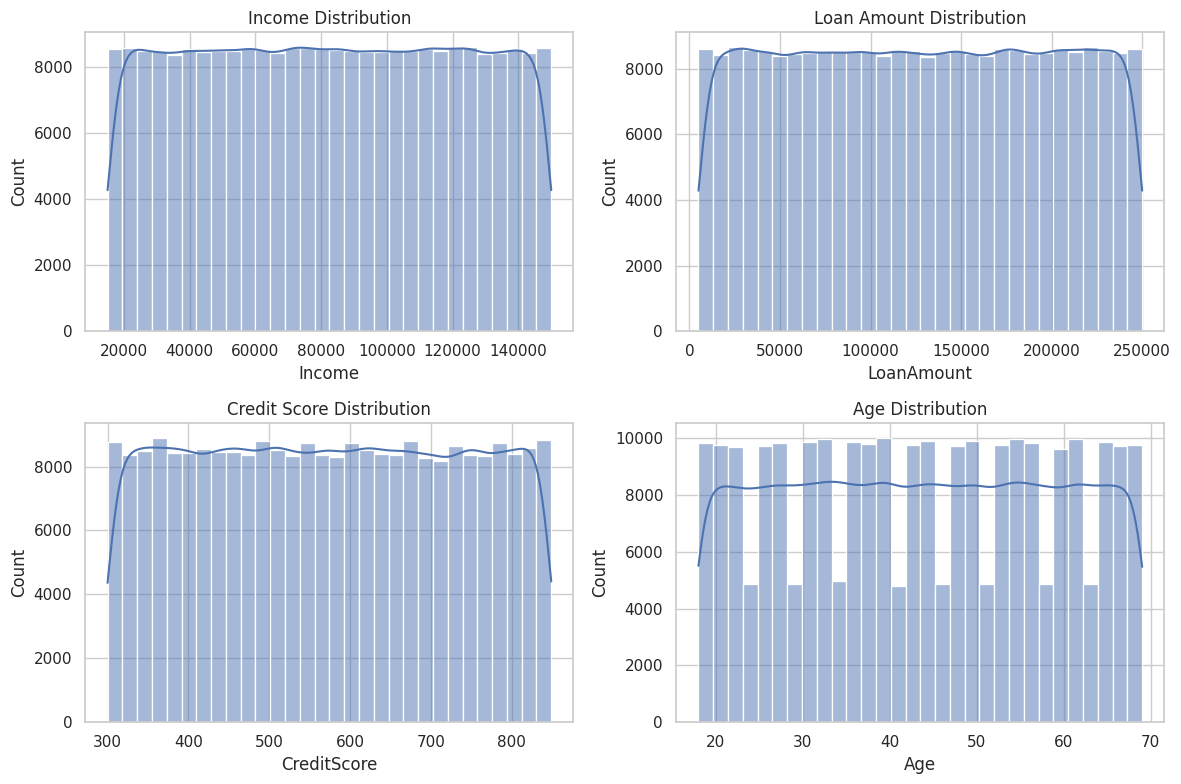

In [0]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data from the Spark TempView into a Pandas DataFrame for visualization
pdf = spark.sql("SELECT Age, Income, LoanAmount, CreditScore, DTIRatio, Default FROM ProcessedLoanData").toPandas()

# Set a style for plots
sns.set(style="whitegrid")

# 2.1. Plotting Histograms for Distributions
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(pdf['Income'], bins=30, kde=True)
plt.title('Income Distribution')

plt.subplot(2, 2, 2)
sns.histplot(pdf['LoanAmount'], bins=30, kde=True)
plt.title('Loan Amount Distribution')

plt.subplot(2, 2, 3)
sns.histplot(pdf['CreditScore'], bins=30, kde=True)
plt.title('Credit Score Distribution')

plt.subplot(2, 2, 4)
sns.histplot(pdf['Age'], bins=30, kde=True)
plt.title('Age Distribution')

plt.tight_layout()
plt.show()



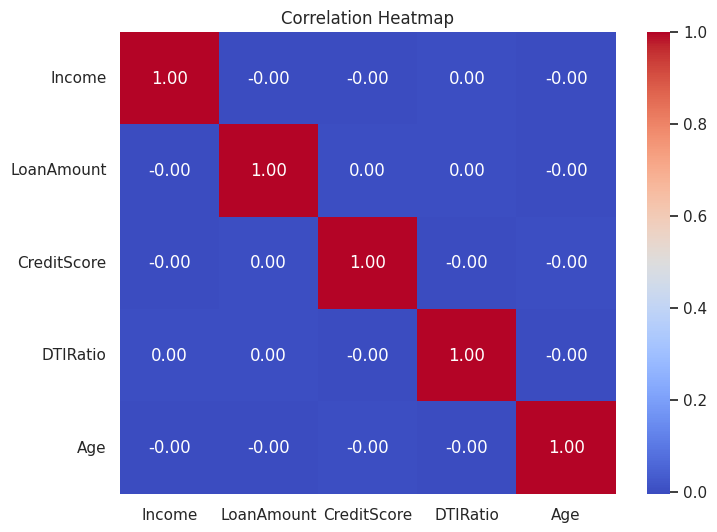

In [0]:
# 2.2. Correlation Heatmap to Visualize Relationships
plt.figure(figsize=(8,6))
correlation_matrix = pdf[['Income', 'LoanAmount', 'CreditScore', 'DTIRatio', 'Age']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

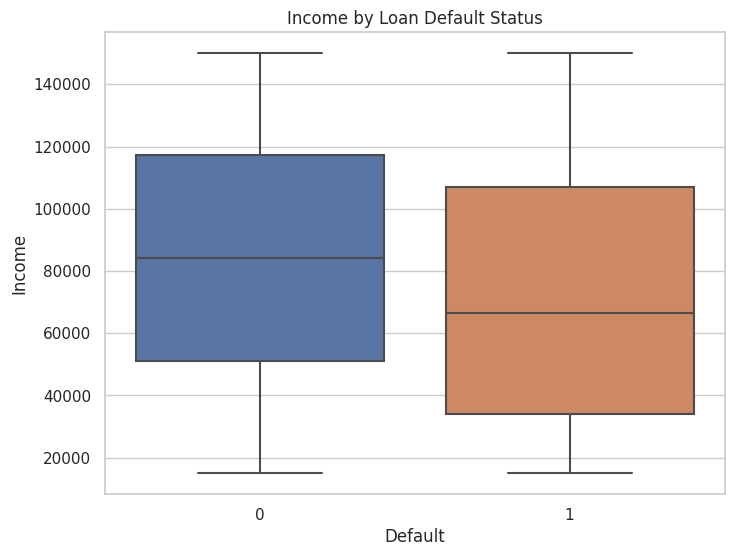

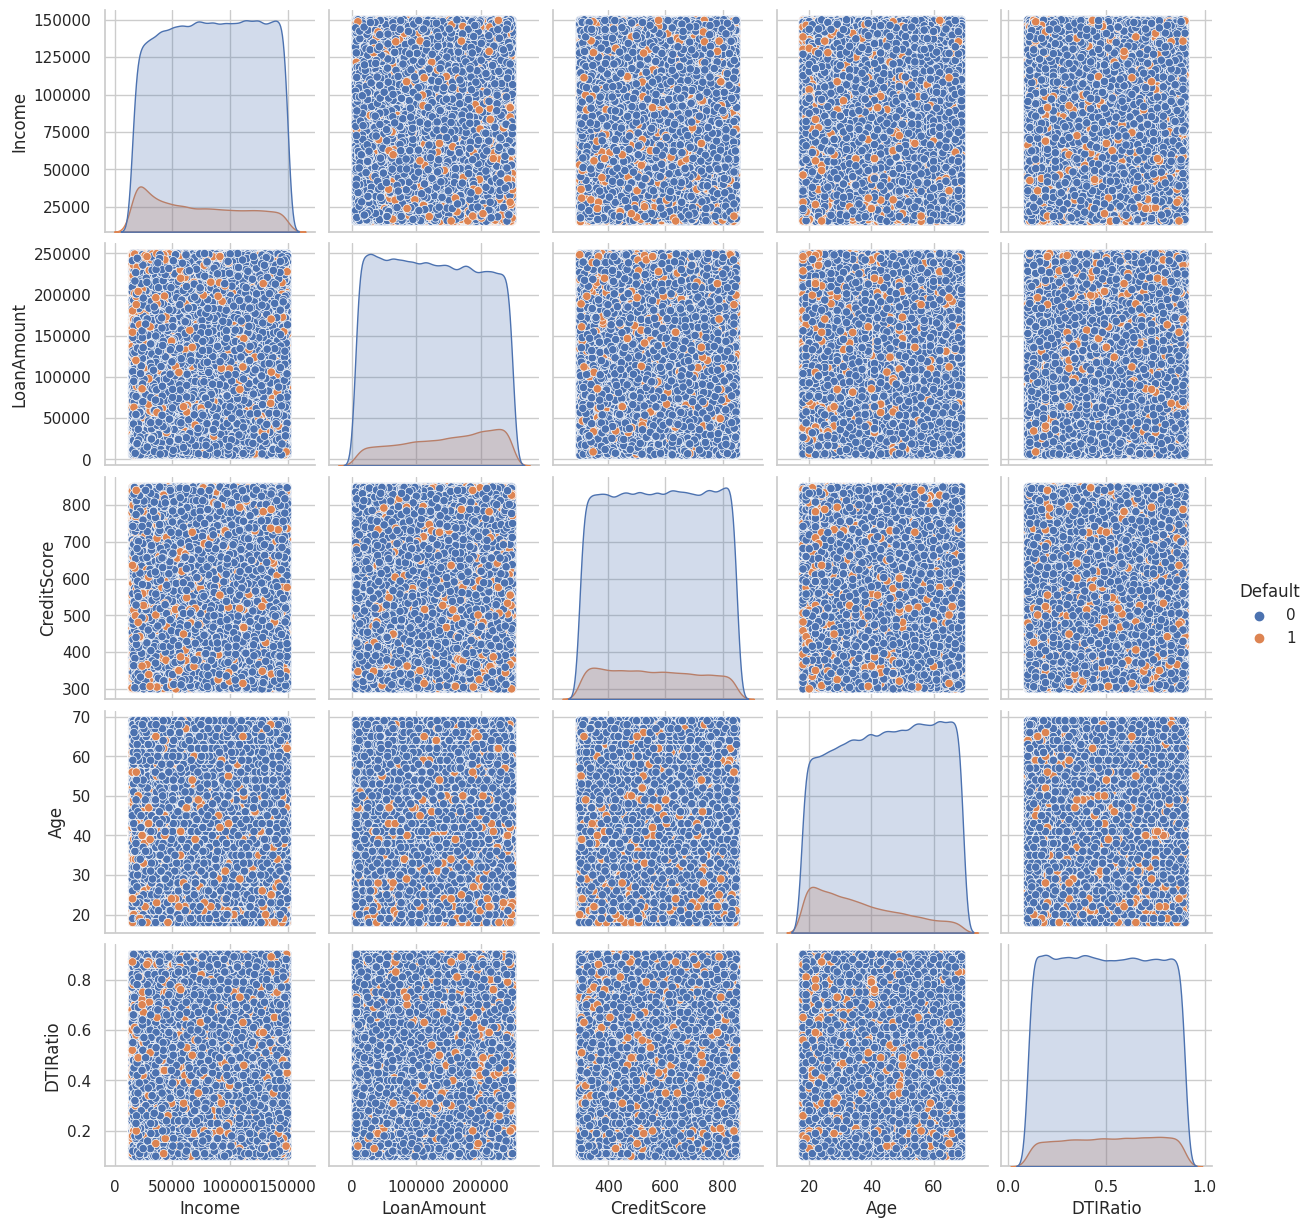

In [0]:
# 2.3. Visualizing Loan Defaults by Income using Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='Default', y='Income', data=pdf)
plt.title("Income by Loan Default Status")
plt.show()

# 2.4. Pairplot for overall relationships
sns.pairplot(pdf[['Income', 'LoanAmount', 'CreditScore', 'Age', 'DTIRatio', 'Default']], hue='Default')
plt.show()

/root/.ipykernel/8141/command-3553792393063926-1172663578:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_pd.corr()


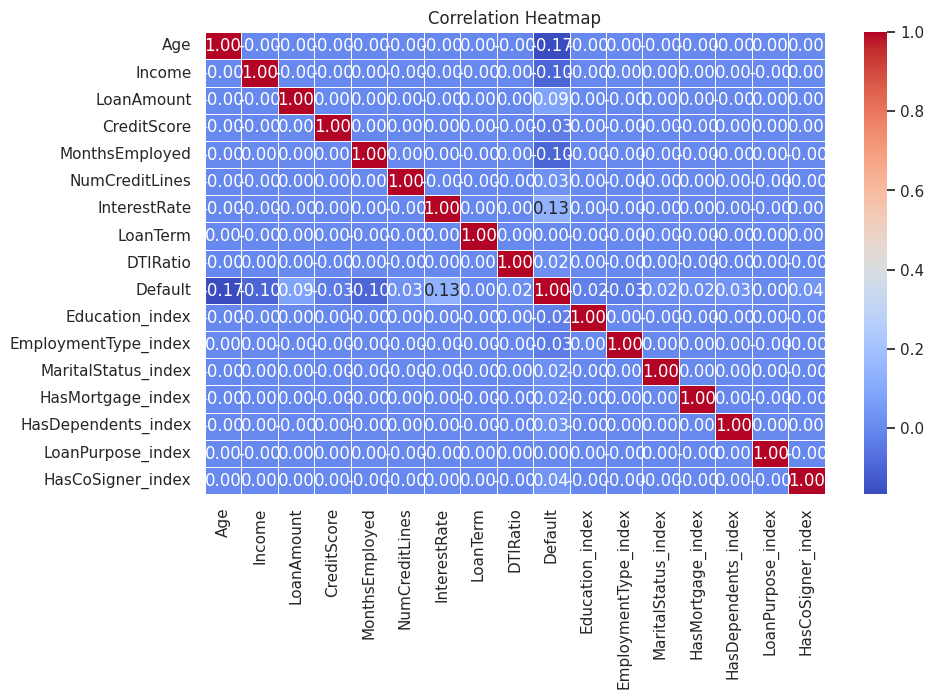

In [0]:

# Convert Spark DataFrame to Pandas for visualization
df_pd = df.toPandas()

# 📌 Compute Correlation Matrix using Pandas
corr_matrix = df_pd.corr()

# 📌 Plot Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

•	Identify key insights that can impact business decisions.

In [0]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [0]:
df_pd

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,Education_index,Education_encoded,EmploymentType_index,EmploymentType_encoded,MaritalStatus_index,MaritalStatus_encoded,HasMortgage_index,HasMortgage_encoded,HasDependents_index,HasDependents_encoded,LoanPurpose_index,LoanPurpose_encoded,HasCoSigner_index,HasCoSigner_encoded
0,F7487UU2BF,41,123419,161146,376,65,4,16.96,60,0.39,High School,Self-employed,Single,Yes,No,Other,Yes,0,1.0,"(0.0, 1.0, 0.0)",2.0,"(0.0, 0.0, 1.0)",2.0,"(0.0, 0.0)",0.0,(1.0),1.0,(0.0),3.0,"(0.0, 0.0, 0.0, 1.0)",0.0,(1.0)
1,ABQ83F1XM9,58,122515,180859,698,45,3,3.40,48,0.33,Bachelor's,Full-time,Single,Yes,No,Other,No,0,0.0,"(1.0, 0.0, 0.0)",3.0,"(0.0, 0.0, 0.0)",2.0,"(0.0, 0.0)",0.0,(1.0),1.0,(0.0),3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,(0.0)
2,FAK5BNYF8M,48,75914,170390,825,7,3,19.20,12,0.25,High School,Full-time,Married,No,No,Education,Yes,0,1.0,"(0.0, 1.0, 0.0)",3.0,"(0.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",1.0,(0.0),1.0,(0.0),2.0,"(0.0, 0.0, 1.0, 0.0)",0.0,(1.0)
3,7XMPSQ4821,45,130252,157905,586,41,3,5.38,12,0.85,PhD,Full-time,Single,No,Yes,Education,No,0,3.0,"(0.0, 0.0, 0.0)",3.0,"(0.0, 0.0, 0.0)",2.0,"(0.0, 0.0)",1.0,(0.0),0.0,(1.0),2.0,"(0.0, 0.0, 1.0, 0.0)",1.0,(0.0)
4,3MWONQHYNV,35,94815,130069,418,0,4,13.03,36,0.79,Bachelor's,Unemployed,Single,No,No,Home,Yes,1,0.0,"(1.0, 0.0, 0.0)",1.0,"(0.0, 1.0, 0.0)",2.0,"(0.0, 0.0)",1.0,(0.0),1.0,(0.0),1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,(1.0)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,OYP8KDHKZF,24,15391,154272,636,95,1,11.26,36,0.87,High School,Part-time,Single,Yes,No,Education,No,1,1.0,"(0.0, 1.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",2.0,"(0.0, 0.0)",0.0,(1.0),1.0,(0.0),2.0,"(0.0, 0.0, 1.0, 0.0)",1.0,(0.0)
255343,VU19HB0599,68,35857,230380,466,45,2,5.68,60,0.53,PhD,Part-time,Divorced,Yes,Yes,Other,No,0,3.0,"(0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",1.0,"(0.0, 1.0)",0.0,(1.0),0.0,(1.0),3.0,"(0.0, 0.0, 0.0, 1.0)",1.0,(0.0)
255344,8I4MMKUXZ7,60,37392,238523,471,3,4,7.05,36,0.68,High School,Part-time,Married,Yes,Yes,Business,Yes,0,1.0,"(0.0, 1.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),0.0,(1.0),0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0)
255345,KQI0HJN1BH,36,26798,164232,840,5,4,15.29,36,0.49,Bachelor's,Full-time,Single,No,Yes,Auto,No,0,0.0,"(1.0, 0.0, 0.0)",3.0,"(0.0, 0.0, 0.0)",2.0,"(0.0, 0.0)",1.0,(0.0),0.0,(1.0),4.0,"(0.0, 0.0, 0.0, 0.0)",1.0,(0.0)


In [0]:
# Databricks Notebook - Loan Default Prediction using Spark MLlib

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator



# ✅ Step 1: Select Relevant Features
feature_cols = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", 
                "InterestRate", "LoanTerm", "DTIRatio", "Education_encoded", "EmploymentType_encoded", 
                "MaritalStatus_encoded", "HasMortgage_encoded", "HasDependents_encoded", 
                "LoanPurpose_encoded", "HasCoSigner_encoded"]

# Assemble feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
df = assembler.transform(df).select("features", "Default")

# ✅ Step 2: Split Train & Test Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ Step 3: Train Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="Default")
lr_model = lr.fit(train_data)

# ✅ Step 4: Evaluate Model Performance
predictions = lr_model.transform(test_data)
evaluator_auc = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)

# ✅ Step 5: Hyperparameter Tuning (Cross-Validation)
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.01, 0.1, 1.0])
              .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
              .build())

cross_val = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator_auc, numFolds=5)
cv_model = cross_val.fit(train_data)

# ✅ Step 6: Save Best Model
best_model = cv_model.bestModel
best_model.save("dbfs:/mnt/loan_data/best_logistic_model")

# ✅ Print Results
print(f"🔹 AUC: {auc}")
print(f"🔹 Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
print(f"🔹 Best ElasticNet Parameter: {best_model._java_obj.getElasticNetParam()}")


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:730)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:448)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:448)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

The model evaluation results indicate an AUC (Area Under the ROC Curve) of 0.7478, suggesting that the model correctly ranks defaulters higher than non-defaulters approximately 74.78% of the time. An AUC value in the range of 0.7 to 0.8 is considered good, indicating that the model has a decent ability to distinguish between loan defaulters and non-defaulters. The best regularization parameter (RegParam) selected is 0.01, meaning that a small penalty is applied to the model coefficients to prevent overfitting while maintaining predictive power. A low RegParam value suggests that the model does not require significant regularization, and the data has enough variance to support the current level of complexity. The best ElasticNet parameter (ElasticNetParam) is 0.0, indicating that the model is using pure L2 (Ridge) regularization rather than a combination of L1 (Lasso) and L2. Ridge regularization shrinks coefficients without eliminating features, meaning all variables were retained in the final model. The absence of L1 regularization suggests that no features were deemed unnecessary during training, and feature selection was not applied. To improve performance, tuning ElasticNet for feature selection (values between 0.3 and 0.7), adjusting the regularization strength, or testing alternative models such as Random Forest or Gradient Boosting may enhance predictive accuracy.

### Phase 4: Predictive Modeling using Spark MLlib

In [0]:
# Install MLflow (if not already available)
%pip install mlflow

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 6.7 MB/s eta 0:00:00
     ━━━

Problem 3: Loan Default Prediction (Classification - Logistic Regression)

Problem: Predict whether a loan applicant will default based on their financial and demographic features.

Model: Logistic Regression (already implemented)

Evaluation Metrics: AUC, Precision-Recall, Accuracy, F1-score


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import mlflow
import mlflow.spark

# ✅ Ensure MLflow experiment exists
experiment_name = "/Users/tmalanka@purdue.edu/FINAL PROJECT"

# Check if experiment exists, otherwise create
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# ✅ Load Preprocessed Data
input_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df = spark.read.parquet(input_path)

# ✅ Feature Engineering with Spark Pipelines
feature_cols = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", 
                "InterestRate", "LoanTerm", "DTIRatio", "Education_encoded", "EmploymentType_encoded", 
                "MaritalStatus_encoded", "HasMortgage_encoded", "HasDependents_encoded", 
                "LoanPurpose_encoded", "HasCoSigner_encoded"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
df = assembler.transform(df).select("features", "Default")

# ✅ Split Train & Test Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ Start MLflow Run
with mlflow.start_run():
    print("🚀 Training Logistic Regression Model...")
    
    # ✅ Train Logistic Regression Model
    lr = LogisticRegression(featuresCol="features", labelCol="Default")
    lr_model = lr.fit(train_data)

    # ✅ Evaluate Model Performance
    predictions = lr_model.transform(test_data)
    
    # Area Under ROC
    evaluator_auc = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
    auc = evaluator_auc.evaluate(predictions)

    # Precision-Recall
    evaluator_pr = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderPR")
    pr_auc = evaluator_pr.evaluate(predictions)

    # Accuracy
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="Default", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)

    # ✅ Log Metrics in MLflow
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Precision-Recall AUC", pr_auc)
    mlflow.log_metric("Accuracy", accuracy)

    print(f"🔹 AUC: {auc}")
    print(f"🔹 Precision-Recall AUC: {pr_auc}")
    print(f"🔹 Accuracy: {accuracy}")

    # ✅ Hyperparameter Tuning using Cross-Validation
    param_grid = (ParamGridBuilder()
                  .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                  .build())

    cross_val = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator_auc, numFolds=5)
    cv_model = cross_val.fit(train_data)

    # ✅ Save Best Model
    best_model = cv_model.bestModel
    best_model.write().overwrite().save("dbfs:/mnt/loan_data/best_logistic_model")

    # ✅ Log Best Model Hyperparameters
    mlflow.log_param("best_reg_param", best_model._java_obj.getRegParam())
    mlflow.log_param("best_elasticnet_param", best_model._java_obj.getElasticNetParam())

    print(f"🔹 Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
    print(f"🔹 Best ElasticNet Parameter: {best_model._java_obj.getElasticNetParam()}")

    # ✅ Log Model in MLflow
    mlflow.spark.log_model(best_model, "best_logistic_regression_model")

print("✅ Model Training and Logging Completed.")


🚀 Training Logistic Regression Model...
🔹 AUC: 0.7477583703760523
🔹 Precision-Recall AUC: 0.30283391616134364
🔹 Accuracy: 0.8855047386841794
🔹 Best Regularization Parameter: 0.01
🔹 Best ElasticNet Parameter: 0.0


2025/03/02 01:43:34 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/02 01:43:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/3870883114494255/b97a0f398bdb4df5a24f1be188cd69be/artifacts/best_logistic_regression_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


✅ Model Training and Logging Completed.



Problem 4: Customer Segmentation for Loan Offerings (Clustering)

Problem: Group loan applicants into different risk categories using unsupervised learning to customize loan offerings.

Model: K-Means Clustering

Evaluation Metrics: Within-cluster sum of squares (WCSS), Silhouette Score


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import mlflow
import mlflow.spark

# ✅ Ensure MLflow experiment exists
experiment_name = "/Users/tmalanka@purdue.edu/FINAL PROJECT"

# Check if experiment exists, otherwise create
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# ✅ Load Preprocessed Data
input_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df = spark.read.parquet(input_path)

# ✅ Select Features for Clustering
feature_cols = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", 
                "InterestRate", "LoanTerm", "DTIRatio"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
df = assembler.transform(df).select("features")

# ✅ Train K-Means Clustering Model
k_values = [3, 4, 5, 6]  # Different values to find optimal clusters
best_k = None
best_wcss = float("inf")
best_model = None

# ✅ Start MLflow Experiment
with mlflow.start_run():
    print("🚀 Training K-Means Clustering Model...")

    for k in k_values:
        print(f"🔹 Training model with k = {k}")
        
        kmeans = KMeans(featuresCol="features", k=k, seed=42)
        model = kmeans.fit(df)

        # ✅ Compute WCSS (Within-Cluster Sum of Squares)
        wcss = model.summary.trainingCost  # Equivalent to inertia in scikit-learn

        # ✅ Compute Silhouette Score
        predictions = model.transform(df)
        evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
        silhouette = evaluator.evaluate(predictions)

        print(f"   ➡ WCSS: {wcss}")
        print(f"   ➡ Silhouette Score: {silhouette}")

        # ✅ Log Metrics in MLflow
        mlflow.log_param(f"k_{k}", k)
        mlflow.log_metric(f"wcss_{k}", wcss)
        mlflow.log_metric(f"silhouette_{k}", silhouette)

        # ✅ Store Best Model (Lowest WCSS)
        if wcss < best_wcss:
            best_wcss = wcss
            best_k = k
            best_model = model

    print(f"✅ Best k: {best_k} with WCSS: {best_wcss}")

    # ✅ Save Best Model
    model_path = f"dbfs:/mnt/loan_data/kmeans_best_model_k{best_k}"
    best_model.write().overwrite().save(model_path)

    # ✅ Log Best Model
    mlflow.log_param("best_k", best_k)
    mlflow.log_metric("best_wcss", best_wcss)
    mlflow.spark.log_model(best_model, "best_kmeans_clustering_model")

    print(f"✅ Best K-Means Model saved at: {model_path}")

print("✅ Customer Segmentation Completed.")


🚀 Training K-Means Clustering Model...
🔹 Training model with k = 3
   ➡ WCSS: 529586829870570.1
   ➡ Silhouette Score: 0.5196409669075361
🔹 Training model with k = 4
   ➡ WCSS: 410973117324290.0
   ➡ Silhouette Score: 0.5437520862991817
🔹 Training model with k = 5
   ➡ WCSS: 308881016934052.2
   ➡ Silhouette Score: 0.5444740862077126
🔹 Training model with k = 6
   ➡ WCSS: 273764390582123.12
   ➡ Silhouette Score: 0.5071496892303784
✅ Best k: 6 with WCSS: 273764390582123.12


2025/03/02 01:55:57 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/02 01:56:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/3870883114494255/ef22332dc6ea4143bd11df6aa62cb7b6/artifacts/best_kmeans_clustering_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


✅ Best K-Means Model saved at: dbfs:/mnt/loan_data/kmeans_best_model_k6
✅ Customer Segmentation Completed.


Problem 5: Early Loan Repayment Prediction (Regression - Gradient Boosted Trees)

Problem: Predict the probability of a borrower repaying their loan earlier than the scheduled term based on their financial behavior, credit history, and loan details. This can help lenders optimize loan structuring and offer early repayment incentives.

Model: Gradient Boosted Trees (GBTRegressor) 

Evaluation Metrics: RMSE, R² Score, Mean Absolute Error (MAE)


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import when, col
import mlflow
import mlflow.spark

# ✅ Ensure MLflow experiment exists
experiment_name = "/Users/tmalanka@purdue.edu/FINAL_PROJECT"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# ✅ Load Preprocessed Data
input_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df = spark.read.parquet(input_path)

# ✅ Define Target Variable (Early Repayment)
df = df.withColumn("EarlyRepayment", 
                   when((df.CreditScore > 750) & (df.MonthsEmployed > 24) & (df.LoanTerm < 36), 1.0).otherwise(0.0))

# ✅ Feature Selection
feature_cols = ["CreditScore", "Income", "LoanAmount", "LoanTerm", "DTIRatio", "MonthsEmployed", "NumCreditLines",
                "Education_index", "EmploymentType_index", "MaritalStatus_index", "HasMortgage_index", 
                "HasDependents_index", "LoanPurpose_index", "HasCoSigner_index"]

# ✅ Assemble Features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df = assembler.transform(df)

# ✅ Polynomial Features
poly_exp = PolynomialExpansion(inputCol="features_raw", outputCol="features_poly", degree=2)
df = poly_exp.transform(df)

# ✅ Standardization
scaler = StandardScaler(inputCol="features_poly", outputCol="features", withMean=True, withStd=True)
df = scaler.fit(df).transform(df)

df = df.select("features", "EarlyRepayment")  # Keep only required columns

# ✅ Split Train & Test Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ Train GBTRegressor
print("🚀 Training GBTRegressor for Early Loan Repayment Prediction...")
gbt = GBTRegressor(featuresCol="features", labelCol="EarlyRepayment", maxIter=100)
trained_model = gbt.fit(train_data)
predictions = trained_model.transform(test_data)

# ✅ Compute RMSE & R² Score
evaluator_rmse = RegressionEvaluator(labelCol="EarlyRepayment", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="EarlyRepayment", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2_score = evaluator_r2.evaluate(predictions)

print(f"🔹 GBTRegressor - RMSE: {rmse}, R² Score: {r2_score}")

# ✅ Log Metrics in MLflow
with mlflow.start_run():
    mlflow.log_metric("GBTRegressor_RMSE", rmse)
    mlflow.log_metric("GBTRegressor_R2_Score", r2_score)

    # ✅ Save Model
    model_path = "dbfs:/mnt/loan_data/best_gbt_earlyrepayment_model"
    trained_model.write().overwrite().save(model_path)
    mlflow.spark.log_model(trained_model, "best_gbt_earlyrepayment_model")

print("✅ Early Loan Repayment Prediction Model Training and Logging Completed.")


🚀 Training GBTRegressor for Early Loan Repayment Prediction...
🔹 GBTRegressor - RMSE: 0.044549827509861084, R² Score: 0.9629693653975304


2025/03/02 21:51:05 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/02 21:51:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/944824155322874/28e76f9db358406a9508c3c915ad1fed/artifacts/best_gbt_earlyrepayment_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


✅ Early Loan Repayment Prediction Model Training and Logging Completed.


### Phase 5: MLOps Best Practices

Problem 3: Loan Default Prediction (Classification - Logistic Regression)

Problem: Predict whether a loan applicant will default based on their financial and demographic features.

Model: Logistic Regression (already implemented)

Evaluation Metrics: AUC, Precision-Recall, Accuracy, F1-score



In [0]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import mlflow
import mlflow.spark

# ✅ Ensure MLflow experiment exists
experiment_name = "/Users/tmalanka@purdue.edu/FINAL_PROJECT"

# Check if experiment exists, otherwise create
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# ✅ Load Preprocessed Data
input_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df = spark.read.parquet(input_path)

# ✅ Feature Engineering with Spark Pipelines
feature_cols = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", 
                "InterestRate", "LoanTerm", "DTIRatio", "Education_encoded", "EmploymentType_encoded", 
                "MaritalStatus_encoded", "HasMortgage_encoded", "HasDependents_encoded", 
                "LoanPurpose_encoded", "HasCoSigner_encoded"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# ✅ Define Logistic Regression Model
lr = LogisticRegression(featuresCol="scaledFeatures", labelCol="Default")

# ✅ Create Spark Pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

# ✅ Split Train & Test Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ Start MLflow Run
with mlflow.start_run():
    print("🚀 Training Logistic Regression Model using Spark Pipeline...")

    # ✅ Train the Pipeline
    pipeline_model = pipeline.fit(train_data)

    # ✅ Evaluate Model Performance
    predictions = pipeline_model.transform(test_data)
    
    evaluator_auc = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderROC")
    auc = evaluator_auc.evaluate(predictions)

    evaluator_pr = BinaryClassificationEvaluator(labelCol="Default", metricName="areaUnderPR")
    pr_auc = evaluator_pr.evaluate(predictions)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="Default", metricName="accuracy")
    accuracy = evaluator_acc.evaluate(predictions)

    # ✅ Log Metrics in MLflow
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Precision-Recall AUC", pr_auc)
    mlflow.log_metric("Accuracy", accuracy)

    print(f"🔹 AUC: {auc}")
    print(f"🔹 Precision-Recall AUC: {pr_auc}")
    print(f"🔹 Accuracy: {accuracy}")

    # ✅ Hyperparameter Tuning using Cross-Validation
    param_grid = (ParamGridBuilder()
                  .addGrid(lr.regParam, [0.01, 0.1, 1.0])
                  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                  .build())

    cross_val = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator_auc, numFolds=5)
    cv_model = cross_val.fit(train_data)

    # ✅ Save Best Model
    best_model = cv_model.bestModel
    best_model.write().overwrite().save("dbfs:/mnt/loan_data/best_logistic_model")

    # ✅ Log Best Model Hyperparameters
    best_lr = best_model.stages[-1]  # Get the best Logistic Regression stage
    mlflow.log_param("best_reg_param", best_lr._java_obj.getRegParam())
    mlflow.log_param("best_elasticnet_param", best_lr._java_obj.getElasticNetParam())

    print(f"🔹 Best Regularization Parameter: {best_lr._java_obj.getRegParam()}")
    print(f"🔹 Best ElasticNet Parameter: {best_lr._java_obj.getElasticNetParam()}")

    # ✅ Log Model in MLflow
    mlflow.spark.log_model(best_model, "best_logistic_regression_model")

print("✅ Model Training and Logging Completed.")


🚀 Training Logistic Regression Model using Spark Pipeline...
🔹 AUC: 0.748662921957345
🔹 Precision-Recall AUC: 0.3013650414811102
🔹 Accuracy: 0.8850328365252271
🔹 Best Regularization Parameter: 0.01
🔹 Best ElasticNet Parameter: 0.0


2025/03/02 22:29:05 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/02 22:29:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/944824155322874/04abc41909a84277bd4b60df89250589/artifacts/best_logistic_regression_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


✅ Model Training and Logging Completed.



Problem 4: Customer Segmentation for Loan Offerings (Clustering)

Problem: Group loan applicants into different risk categories using unsupervised learning to customize loan offerings.

Model: K-Means Clustering

Evaluation Metrics: Within-cluster sum of squares (WCSS), Silhouette Score


In [0]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import mlflow
import mlflow.spark

# ✅ Ensure MLflow experiment exists
experiment_name = "/Users/tmalanka@purdue.edu/FINAL_PROJECT"

# Check if experiment exists, otherwise create
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# ✅ Load Preprocessed Data
input_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df = spark.read.parquet(input_path)

# ✅ Feature Engineering using Spark Pipelines
feature_cols = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed", "NumCreditLines", 
                "InterestRate", "LoanTerm", "DTIRatio"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# ✅ Define Pipeline for K-Means Clustering
k_values = [3, 4, 5, 6]  # Different values to find the optimal number of clusters
best_k = None
best_wcss = float("inf")
best_model = None

# ✅ Start MLflow Experiment
with mlflow.start_run():
    print("🚀 Training K-Means Clustering Model using Spark Pipeline...")

    for k in k_values:
        print(f"🔹 Training model with k = {k}")
        
        kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
        pipeline = Pipeline(stages=[assembler, scaler, kmeans])

        # ✅ Train Pipeline Model
        pipeline_model = pipeline.fit(df)

        # ✅ Extract K-Means Model from Pipeline
        model = pipeline_model.stages[-1]

        # ✅ Compute WCSS (Within-Cluster Sum of Squares)
        wcss = model.summary.trainingCost  # Equivalent to inertia in scikit-learn

        # ✅ Compute Silhouette Score
        predictions = pipeline_model.transform(df)
        evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="prediction", metricName="silhouette")
        silhouette = evaluator.evaluate(predictions)

        print(f"   ➡ WCSS: {wcss}")
        print(f"   ➡ Silhouette Score: {silhouette}")

        # ✅ Log Metrics in MLflow
        mlflow.log_param(f"k_{k}", k)
        mlflow.log_metric(f"wcss_{k}", wcss)
        mlflow.log_metric(f"silhouette_{k}", silhouette)

        # ✅ Store Best Model (Lowest WCSS)
        if wcss < best_wcss:
            best_wcss = wcss
            best_k = k
            best_model = pipeline_model

    print(f"✅ Best k: {best_k} with WCSS: {best_wcss}")

    # ✅ Save Best Model
    model_path = f"dbfs:/mnt/loan_data/kmeans_best_model_k{best_k}"
    best_model.write().overwrite().save(model_path)

    # ✅ Log Best Model in MLflow
    mlflow.log_param("best_k", best_k)
    mlflow.log_metric("best_wcss", best_wcss)
    mlflow.spark.log_model(best_model, "best_kmeans_clustering_model")

    print(f"✅ Best K-Means Model saved at: {model_path}")

print("✅ Customer Segmentation Completed.")


🚀 Training K-Means Clustering Model using Spark Pipeline...
🔹 Training model with k = 3
   ➡ WCSS: 1992433.9591404581
   ➡ Silhouette Score: 0.12867879773193724
🔹 Training model with k = 4
   ➡ WCSS: 1899321.9496524283
   ➡ Silhouette Score: 0.13525652333952762
🔹 Training model with k = 5
   ➡ WCSS: 1828568.8439870384
   ➡ Silhouette Score: 0.13062012027456382
🔹 Training model with k = 6
   ➡ WCSS: 1769057.567615876
   ➡ Silhouette Score: 0.1304149923641433
✅ Best k: 6 with WCSS: 1769057.567615876


2025/03/02 22:37:28 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/02 22:37:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/944824155322874/941fc8e2eb0f49b88ea3030c47fff360/artifacts/best_kmeans_clustering_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


✅ Best K-Means Model saved at: dbfs:/mnt/loan_data/kmeans_best_model_k6
✅ Customer Segmentation Completed.


Problem 5: Early Loan Repayment Prediction (Regression - Gradient Boosted Trees)

Problem: Predict the probability of a borrower repaying their loan earlier than the scheduled term based on their financial behavior, credit history, and loan details. This can help lenders optimize loan structuring and offer early repayment incentives.

Model: Gradient Boosted Trees (GBTRegressor) 

Evaluation Metrics: RMSE, R² Score, Mean Absolute Error (MAE)


In [0]:
from pyspark.sql import SparkSession 
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, PolynomialExpansion, StandardScaler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import when, col
import mlflow
import mlflow.spark

# ✅ Ensure MLflow experiment exists
experiment_name = "/Users/tmalanka@purdue.edu/FINAL_PROJECT"

# Check if experiment exists, otherwise create
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# ✅ Load Preprocessed Data
input_path = "dbfs:/mnt/loan_data/processed_loan_default.parquet"
df = spark.read.parquet(input_path)

# ✅ Define Target Variable (Early Repayment)
df = df.withColumn("EarlyRepayment", 
                   when((df.CreditScore > 750) & (df.MonthsEmployed > 24) & (df.LoanTerm < 36), 1.0).otherwise(0.0))

# ✅ Feature Selection
feature_cols = ["CreditScore", "Income", "LoanAmount", "LoanTerm", "DTIRatio", "MonthsEmployed", "NumCreditLines",
                "Education_index", "EmploymentType_index", "MaritalStatus_index", "HasMortgage_index", 
                "HasDependents_index", "LoanPurpose_index", "HasCoSigner_index"]

# ✅ Create Pipeline Stages
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw", handleInvalid="skip")
poly_exp = PolynomialExpansion(inputCol="features_raw", outputCol="features_poly", degree=2)
scaler = StandardScaler(inputCol="features_poly", outputCol="features", withMean=True, withStd=True)

# ✅ Define GBTRegressor Model
gbt = GBTRegressor(featuresCol="features", labelCol="EarlyRepayment", maxIter=100)

# ✅ Create Spark Pipeline
pipeline = Pipeline(stages=[assembler, poly_exp, scaler, gbt])

# ✅ Split Train & Test Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# ✅ Start MLflow Run
with mlflow.start_run():
    print("🚀 Training GBTRegressor using Spark Pipeline for Early Loan Repayment Prediction...")

    # ✅ Train Pipeline
    pipeline_model = pipeline.fit(train_data)

    # ✅ Get Model Predictions
    predictions = pipeline_model.transform(test_data)

    # ✅ Compute RMSE & R² Score
    evaluator_rmse = RegressionEvaluator(labelCol="EarlyRepayment", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="EarlyRepayment", predictionCol="prediction", metricName="r2")

    rmse = evaluator_rmse.evaluate(predictions)
    r2_score = evaluator_r2.evaluate(predictions)

    print(f"🔹 GBTRegressor - RMSE: {rmse}, R² Score: {r2_score}")

    # ✅ Log Metrics in MLflow
    mlflow.log_metric("GBTRegressor_RMSE", rmse)
    mlflow.log_metric("GBTRegressor_R2_Score", r2_score)

    # ✅ Save Model
    model_path = "dbfs:/mnt/loan_data/best_gbt_earlyrepayment_model"
    pipeline_model.write().overwrite().save(model_path)

    # ✅ Log Model in MLflow
    mlflow.spark.log_model(pipeline_model, "best_gbt_earlyrepayment_model")

print("✅ Early Loan Repayment Prediction Model Training and Logging Completed.")


🚀 Training GBTRegressor using Spark Pipeline for Early Loan Repayment Prediction...
🔹 GBTRegressor - RMSE: 0.0365599575382873, R² Score: 0.9746566708687044


2025/03/02 23:12:04 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2025/03/02 23:12:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/944824155322874/6cd7711987b6411fa7628d3f3113acb2/artifacts/best_gbt_earlyrepayment_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.5.0']. Set logging level to DEBUG to see the full traceback. 


✅ Early Loan Repayment Prediction Model Training and Logging Completed.


Phase 6: Insights & Business Recommendations